In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [0]:
import sys
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
import os
import numpy as np
import pickle, bz2
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline

Using TensorFlow backend.


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
!wget nc https://github.com/cristianru31/dataset_kaggle/blob/master/kaggle_json.zip?raw=true -O kaggle_json.zip
!unzip kaggle_json.zip

In [0]:
from google.colab import files
!ls -lha kaggle.json
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!unzip alzheimers-dataset-4-class-of-images.zip

# Data pre-processing

In [0]:
TRAIN_DIR = 'Alzheimer_s Dataset/train/'
TEST_DIR = 'Alzheimer_s Dataset/test/'
IMAGE_SIZE = 176
CLASSES = ['NonDemented','VeryMildDemented','MildDemented']

train_images = []
test_images = []
train_labels = []
test_labels = []

i=0
for klass in CLASSES:
  print(klass)

  #Train
  train_labels.append(np.ones(len(os.listdir(TRAIN_DIR + klass)))*i)
  for image in os.listdir(TRAIN_DIR + klass):
    img_aux=img.imread(TRAIN_DIR + klass + '/' + image)
    rgb_img=np.dstack((img_aux, img_aux, img_aux))# convert 1 channel to 3 channels
    train_images.append(rgb_img)

  #Test
  test_labels.append(np.ones(len(os.listdir(TEST_DIR + klass)))*i)
  for image in os.listdir(TEST_DIR + klass):
    img_aux=img.imread(TEST_DIR + klass + '/' + image)# convert 1 channel to 3 channels
    rgb_img=np.dstack((img_aux, img_aux, img_aux))
    test_images.append(rgb_img)

  i+=1

train_labels = np.concatenate(train_labels)
test_labels = np.concatenate(test_labels)

print('Data Train: ',np.shape(train_images))
print('Data Test: ',np.shape(test_images))
print('Labels Train: ',np.shape(train_labels))
print('Labels Test: ',np.shape(test_labels))


NonDemented
VeryMildDemented
MildDemented
Data Train:  (5069, 208, 176, 3)
Data Test:  (1267, 208, 176, 3)
Labels Train:  (5069,)
Labels Test:  (1267,)


In [0]:
x_train=np.array(train_images)
x_test=np.array(test_images)
y_train=np.array(train_labels)
y_test=np.array(test_labels)

# Resize images 

In [0]:
from skimage.transform import resize

x_train = resize(x_train, output_shape=(x_train.shape[0], 32, 32, 3), anti_aliasing=False)
x_test = resize(x_test, output_shape=(x_test.shape[0], 32, 32, 3), anti_aliasing=False)


In [0]:
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((1267,), (5069,), (1267, 32, 32, 3), (5069, 32, 32, 3))

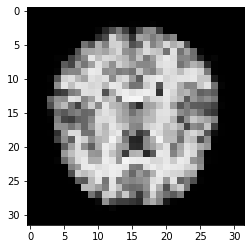

In [0]:
plt.imshow(x_train[300])

# MODEL

In [0]:
def get_model(num_classes, img_size=32, compile=True,reg=.0001, drop=0.4):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu",kernel_regularizer=l2(reg))(inputs) #Esta es la capa de la estructura de Alexnet
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(256,(5,5), activation="relu",kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
num_classes = len(np.unique(train_labels))
model1 = get_model(num_classes=3,reg=.0001, drop=0.4)
model1.summary()

using 3 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)     

## Train from scratch

In [0]:
!rm -rf ./log/model1_transfer
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/model1_transfer', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("experimentos_transfer/best_model1.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model1.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0428 16:10:57.977791 140497245173568 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0428 16:10:57.978666 140497245173568 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.3422 - accuracy: 0.4466
Epoch 00001: val_loss improved from inf to 2.45135, saving model to experimentos_transfer/best_model1.hdf5
5069/5069 [==============================] - 11s 2ms/sample - loss: 1.3427 - accuracy: 0.4464 - val_loss: 2.4514 - val_accuracy: 0.5367
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.1111 - accuracy: 0.4911
Epoch 00002: val_loss improved from 2.45135 to 1.84915, saving model to experimentos_transfer/best_model1.hdf5
5069/5069 [==============================] - 10s 2ms/sample - loss: 1.1117 - accuracy: 0.4904 - val_loss: 1.8492 - val_accuracy: 0.5051
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.0340 - accuracy: 0.5065
Epoch 00003: val_loss did not improve from 1.84915
5069/5069 [==============================] - 10s 2ms/sample - loss: 1.0335 - accuracy: 0.5068 - val_loss: 1.9175 - va

In [0]:
model1.load_weights('experimentos_transfer/best_model1.hdf5')

Normalized confusion matrix
[[0.0421875  0.9578125  0.        ]
 [0.02455357 0.97544643 0.        ]
 [0.02234637 0.94972067 0.02793296]]


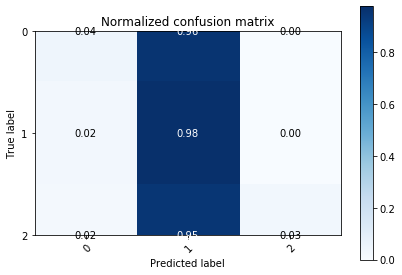

In [0]:
test_preds = model1.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2', '3'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.3701657458563536
Accuracy Balanceado: 0.3485222964884278


# transfer learning without layer freezing 



Load Alexnet

In [0]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1,4M -rw-r--r-- 1 cristian cristian 1,4M mar 13 15:26 local/data/alexnet_conv1_conv2.pklz


In [0]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")

alex_w1 = alex_c12[b"conv1"][0]
alex_bias1 = alex_c12[b"conv1"][1]

alex_w1.shape, alex_bias1.shape

((11, 11, 3, 96), (96,))

In [0]:
alex_w2 = alex_c12[b"conv2"][0]
alex_bias2 = alex_c12[b"conv2"][1]

alex_w2.shape, alex_bias2.shape

((5, 5, 48, 256), (256,))

Duplicate the numbers of channel in the second layer

In [0]:
alex_w2=np.concatenate((alex_w2,alex_w2),axis=2)
alex_w2.shape, alex_bias2.shape

((5, 5, 96, 256), (256,))

In [0]:
model2 = get_model(num_classes=3,reg=.0001, drop=0.4)
w = model2.get_weights()
for i in w:
    print(i.shape)

using 3 classes
(11, 11, 3, 96)
(96,)
(5, 5, 96, 256)
(256,)
(2304, 128)
(128,)
(128,)
(128,)
(128,)
(128,)
(128, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64, 3)
(3,)


In [0]:
w[0]=alex_w1
print('copying weights 0 -->',w[0].shape)

w[1]=alex_bias1
print('copying weights 1 -->',w[1].shape)

w[2]=alex_w2
print('copying weights 2 -->',w[2].shape)

w[3]=alex_bias2
print('copying weights 3 -->',w[3].shape)

copying weights 0 --> (11, 11, 3, 96)
copying weights 1 --> (96,)
copying weights 2 --> (5, 5, 96, 256)
copying weights 3 --> (256,)


In [0]:
model2.set_weights(w)

Check the weights from distribution

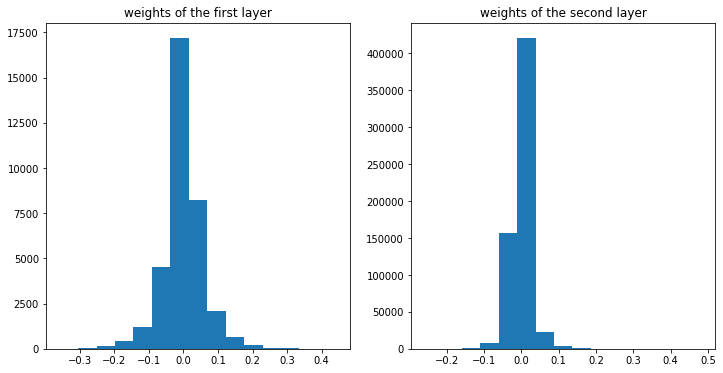

In [0]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.hist(w[0].flatten(),bins=15)
plt.title('weights of the first layer')

plt.subplot(1,2,2)
plt.hist(w[2].flatten(),bins=15)
plt.title('weights of the second layer')
plt.show()

Train without frozen layers

In [0]:
!rm -rf ./log/model2_transfer
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/model2_transfer', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("experimentos_transfer/best_model2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model2.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0428 16:14:27.156952 140497245173568 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0428 16:14:27.158059 140497245173568 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.2817 - accuracy: 0.4790
Epoch 00001: val_loss improved from inf to 1.26289, saving model to experimentos_transfer/best_model2.hdf5
5069/5069 [==============================] - 11s 2ms/sample - loss: 1.2804 - accuracy: 0.4794 - val_loss: 1.2629 - val_accuracy: 0.5107
Epoch 2/20
5056/5069 [============================>.] - ETA: 0s - loss: 1.0589 - accuracy: 0.5435
Epoch 00002: val_loss improved from 1.26289 to 1.16024, saving model to experimentos_transfer/best_model2.hdf5
5069/5069 [==============================] - 10s 2ms/sample - loss: 1.0584 - accuracy: 0.5437 - val_loss: 1.1602 - val_accuracy: 0.4554
Epoch 3/20
5056/5069 [============================>.] - ETA: 0s - loss: 0.9342 - accuracy: 0.5864
Epoch 00003: val_loss did not improve from 1.16024
5069/5069 [==============================] - 10s 2ms/sample - loss: 0.9341 - accuracy: 0.5861 - val_loss: 3.4127 - va

Normalized confusion matrix
[[0.721875   0.234375   0.04375   ]
 [0.32366071 0.50669643 0.16964286]
 [0.16759777 0.34636872 0.48603352]]


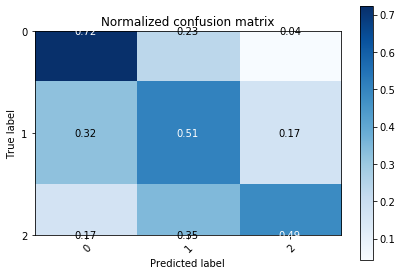

In [0]:
model2.load_weights('experimentos_transfer/best_model2.hdf5')
test_preds = model2.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.6124704025256511
Accuracy Balanceado: 0.571534982708167


Check that the weights have changed.

In [0]:
w_aux = model2.get_weights()[0]
print('Change in parameters 0: ',np.mean(np.abs(w_aux-alex_w1)))

w_aux = model2.get_weights()[1]
print('Change in parameters 1: ',np.mean(np.abs(w_aux-alex_bias1)))

w_aux = model2.get_weights()[2]
print('Change in parameters 2: ',np.mean(np.abs(w_aux-alex_w2)))

w_aux = model2.get_weights()[3]
print('Change in parameters 3: ',np.mean(np.abs(w_aux-alex_bias2)))

Change in parameters 0:  0.022125136
Change in parameters 1:  0.021828001
Change in parameters 2:  0.0153156975
Change in parameters 3:  0.024699654


# Transfer learning with layer freezing 

1. Freezing the weights of the first layer

In [0]:
def get_model(num_classes, img_size=32, compile=True,reg=.0001, drop=0.4):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu",kernel_regularizer=l2(reg),trainable=False)(inputs) #Esta es la capa de la estructura de Alexnet
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(256,(5,5), activation="relu",kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model3 = get_model(num_classes=3,reg=.0001, drop=0.4)
w3 = model3.get_weights()

using 3 classes


In [0]:
w3[0]=alex_w1
print('copying weights 0 -->',w[0].shape)

w3[1]=alex_bias1
print('copying weights 1 -->',w[1].shape)

w3[2]=alex_w2
print('copying weights 2 -->',w[2].shape)

w3[3]=alex_bias2
print('copying weights 3 -->',w[3].shape)

copying weights 0 --> (11, 11, 3, 96)
copying weights 1 --> (96,)
copying weights 2 --> (5, 5, 96, 256)
copying weights 3 --> (256,)


In [0]:
model3.set_weights(w3)

In [0]:
!rm -rf ./log/model3_transfer
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/model3_transfer', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("experimentos_transfer/best_model3.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model3.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0428 16:17:59.117257 140497245173568 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0428 16:17:59.118742 140497245173568 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
5024/5069 [============================>.] - ETA: 0s - loss: 1.2856 - accuracy: 0.4904
Epoch 00001: val_loss improved from inf to 1.32829, saving model to experimentos_transfer/best_model3.hdf5
5069/5069 [==============================] - 6s 1ms/sample - loss: 1.2822 - accuracy: 0.4918 - val_loss: 1.3283 - val_accuracy: 0.5209
Epoch 2/20
5024/5069 [============================>.] - ETA: 0s - loss: 1.0234 - accuracy: 0.5744
Epoch 00002: val_loss improved from 1.32829 to 1.08532, saving model to experimentos_transfer/best_model3.hdf5
5069/5069 [==============================] - 5s 1ms/sample - loss: 1.0229 - accuracy: 0.5759 - val_loss: 1.0853 - val_accuracy: 0.5493
Epoch 3/20
5024/5069 [============================>.] - ETA: 0s - loss: 0.8800 - accuracy: 0.6292
Epoch 00003: val_loss improved from 1.08532 to 1.04483, saving model to experimentos_transfer/best_model3.hdf5
5069/5069 [==============================] - 5s 1ms/sample 

Normalized confusion matrix
[[0.7796875  0.0875     0.1328125 ]
 [0.40625    0.28348214 0.31026786]
 [0.2122905  0.06703911 0.72067039]]


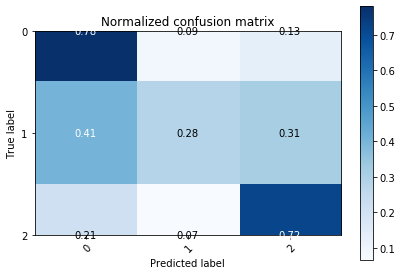

In [0]:
model3.load_weights('experimentos_transfer/best_model3.hdf5')
test_preds = model3.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.595895816890292
Accuracy Balanceado: 0.5946133446395317


Check that the weights have changed.

In [0]:
w_aux = model3.get_weights()[0]
print('Change in parameters 0: ',np.mean(np.abs(w_aux-alex_w1)))

w_aux = model3.get_weights()[1]
print('Change in parameters 1: ',np.mean(np.abs(w_aux-alex_bias1)))

w_aux = model3.get_weights()[2]
print('Change in parameters 2: ',np.mean(np.abs(w_aux-alex_w2)))

w_aux = model3.get_weights()[3]
print('Change in parameters 3: ',np.mean(np.abs(w_aux-alex_bias2)))

Change in parameters 0:  0.0
Change in parameters 1:  0.0
Change in parameters 2:  0.021371232
Change in parameters 3:  0.024263281


2. Freezing the weights of the two layers

In [0]:
def get_model(num_classes, img_size=32, compile=True,reg=.0001, drop=0.4):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu",kernel_regularizer=l2(reg),trainable=False)(inputs) #Esta es la capa de la estructura de Alexnet
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(256,(5,5), activation="relu",kernel_regularizer=l2(reg),trainable=False)(layers)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=l2(reg))(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dropout(drop)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [0]:
model4 = get_model(num_classes=3,reg=.0001, drop=0.4)
w4 = model4.get_weights()

using 3 classes


In [0]:
w4[0]=alex_w1
print('copying weights 0 -->',w[0].shape)

w4[1]=alex_bias1
print('copying weights 1 -->',w[1].shape)

w4[2]=alex_w2
print('copying weights 2 -->',w[2].shape)

w4[3]=alex_bias2
print('copying weights 3 -->',w[3].shape)

copying weights 0 --> (11, 11, 3, 96)
copying weights 1 --> (96,)
copying weights 2 --> (5, 5, 96, 256)
copying weights 3 --> (256,)


In [0]:
model4.set_weights(w4)

In [0]:
!rm -rf ./log/model4_transfer
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/model4_transfer', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("experimentos_transfer/best_model4.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
model4.fit(x_train, y_train, epochs=20, batch_size=32,verbose=True,validation_data=(x_test, y_test),callbacks=[tb_callback,checkpoint])

W0428 16:19:46.055037 140497245173568 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0428 16:19:46.055894 140497245173568 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 5069 samples, validate on 1267 samples
Epoch 1/20
4960/5069 [============================>.] - ETA: 0s - loss: 1.3428 - accuracy: 0.4750
Epoch 00001: val_loss improved from inf to 1.29277, saving model to experimentos_transfer/best_model4.hdf5
5069/5069 [==============================] - 4s 752us/sample - loss: 1.3376 - accuracy: 0.4756 - val_loss: 1.2928 - val_accuracy: 0.5264
Epoch 2/20
4992/5069 [============================>.] - ETA: 0s - loss: 1.0721 - accuracy: 0.5461
Epoch 00002: val_loss improved from 1.29277 to 1.21253, saving model to experimentos_transfer/best_model4.hdf5
5069/5069 [==============================] - 3s 632us/sample - loss: 1.0723 - accuracy: 0.5459 - val_loss: 1.2125 - val_accuracy: 0.5107
Epoch 3/20
4960/5069 [============================>.] - ETA: 0s - loss: 0.9706 - accuracy: 0.5784
Epoch 00003: val_loss did not improve from 1.21253
5069/5069 [==============================] - 3s 623us/sample - loss: 0.9689 - accuracy: 0.5792 - val_loss: 1.3642 -

Normalized confusion matrix
[[0.8421875  0.1578125  0.        ]
 [0.60714286 0.38839286 0.00446429]
 [0.37988827 0.54748603 0.0726257 ]]


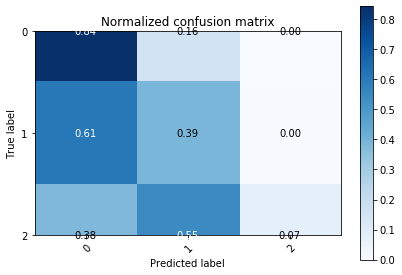

In [0]:
model4.load_weights('experimentos_transfer/best_model4.hdf5')
test_preds = model4.predict(x_test).argmax(axis=1)
class_names = np.array(['0','1', '2'])
plot_confusion_matrix(y_test, test_preds, classes=class_names, normalize=True)

In [0]:
acc=accuracy_score(y_test, test_preds)
acc_bal=balanced_accuracy_score(y_test, test_preds)

print("Accuracy :", acc)
print("Accuracy Balanceado:", acc_bal)

Accuracy : 0.5730071033938438
Accuracy Balanceado: 0.4344020184889598


Check that the weights have changed.

In [0]:
w_aux = model4.get_weights()[0]
print('Change in parameters 0: ',np.mean(np.abs(w_aux-alex_w1)))

w_aux = model4.get_weights()[1]
print('Change in parameters 1: ',np.mean(np.abs(w_aux-alex_bias1)))

w_aux = model4.get_weights()[2]
print('Change in parameters 2: ',np.mean(np.abs(w_aux-alex_w2)))

w_aux = model4.get_weights()[3]
print('Change in parameters 3: ',np.mean(np.abs(w_aux-alex_bias2)))

Change in parameters 0:  0.0
Change in parameters 1:  0.0
Change in parameters 2:  0.0
Change in parameters 3:  0.0


In [0]:
try:
    %load_ext tensorboard
    %tensorboard --logdir logs

except:
    print ("not in colab")

Reusing TensorBoard on port 6007 (pid 29689), started 1 day, 15:12:43 ago. (Use '!kill 29689' to kill it.)